In [57]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)  # Crop to the desired output shape
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x, y = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        self.compiled_metrics.update_state(y, reconstructed_x)

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 88, 8)        32          ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 44, 8)       0           ['conv1d_5[0][0]']               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d_2[0][0]']        
                                                                                            

In [58]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]
y_train_labels = y_train
y_test_labels = y_test

#print(x_train)
#print(x_test)
#print(y_train)
#print(y_test)

# Convert columns to NumPy arrays
x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

# Apply scaling to the features
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

#print(x_train)
#print(x_test)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [59]:
learn_rate = [0.005, 0.01, 0.05, 0.1]
batch_size = [32, 64, 128, 256]
#learn_rate = [0.005, 0.01]
#batch_size = [32, 64]
param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        # Create the VAE model with the current hyperparameters
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

        # Train the model
        vae.fit(x_train, batch_size=bs, epochs=5, validation_data=(x_test, y_test))

        # Evaluate the model on the validation set
        score = vae.evaluate(x_test, y_test)

        # Update the best score and parameters if needed
        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Epoch 1/5
262/262 [==============================] - 4s 8ms/step - loss: 1.1828 - reconstruction_loss: 1.0411 - kl_loss: 8.0708e-04 - val_total_loss: 0.9130 - val_reconstruction_loss: 0.9128 - val_kl_loss: 1.4650e-04
Epoch 2/5
262/262 [==============================] - 2s 7ms/step - loss: 0.9746 - reconstruction_loss: 0.9663 - kl_loss: 1.1991e-05 - val_total_loss: 0.9407 - val_reconstruction_loss: 0.9407 - val_kl_loss: 3.0796e-07
Epoch 3/5
262/262 [==============================] - 2s 7ms/step - loss: 0.9691 - reconstruction_loss: 0.9669 - kl_loss: 9.3518e-06 - val_total_loss: 0.9070 - val_reconstruction_loss: 0.9070 - val_kl_loss: 3.8743e-06
Epoch 4/5
262/262 [==============================] - 2s 7ms/step - loss: 0.9661 - reconstruction_loss: 0.9645 - kl_loss: 7.9213e-06 - val_total_loss: 0.9096 - val_reconstruction_loss: 0.9096 - val_kl_loss: 8.6725e-06
Epoch 5/5
66/66 [==============================] - 0s 2ms/step - total_loss: 0.9336 - reconstruction_loss: 0.9336 - kl_loss: 1.0610e

66/66 [==============================] - 0s 2ms/step - total_loss: 0.9225 - reconstruction_loss: 0.9225 - kl_loss: 0.0000e+00
Epoch 1/5
33/33 [==============================] - 3s 34ms/step - loss: 0.9778 - reconstruction_loss: 0.9676 - kl_loss: 7.5915e-06 - val_total_loss: 0.8717 - val_reconstruction_loss: 0.8717 - val_kl_loss: 9.5367e-07
Epoch 2/5
33/33 [==============================] - 1s 27ms/step - loss: 0.9468 - reconstruction_loss: 0.9530 - kl_loss: 2.8808e-07 - val_total_loss: 0.8723 - val_reconstruction_loss: 0.8723 - val_kl_loss: 0.0000e+00
Epoch 3/5
33/33 [==============================] - 1s 26ms/step - loss: 0.9453 - reconstruction_loss: 0.9539 - kl_loss: 5.4005e-07 - val_total_loss: 0.8647 - val_reconstruction_loss: 0.8647 - val_kl_loss: 5.6624e-07
Epoch 4/5
33/33 [==============================] - 1s 26ms/step - loss: 0.9382 - reconstruction_loss: 0.9521 - kl_loss: 1.2192e-07 - val_total_loss: 0.8675 - val_reconstruction_loss: 0.8675 - val_kl_loss: 0.0000e+00
Epoch 5/5


Epoch 4/5
131/131 [==============================] - 1s 9ms/step - loss: 1.5812 - reconstruction_loss: 1.6442 - kl_loss: 0.0018 - val_total_loss: 1.8062 - val_reconstruction_loss: 1.8020 - val_kl_loss: 0.0042
Epoch 5/5
66/66 [==============================] - 0s 2ms/step - total_loss: 1.8139 - reconstruction_loss: 1.8134 - kl_loss: 5.1421e-04
Epoch 1/5
66/66 [==============================] - 3s 19ms/step - loss: 1.7732 - reconstruction_loss: 1.7706 - kl_loss: 0.0049 - val_total_loss: 1.8101 - val_reconstruction_loss: 1.8099 - val_kl_loss: 2.6131e-04
Epoch 2/5
66/66 [==============================] - 1s 14ms/step - loss: 1.7729 - reconstruction_loss: 1.7598 - kl_loss: 0.0018 - val_total_loss: 1.8095 - val_reconstruction_loss: 1.8095 - val_kl_loss: 9.3877e-06
Epoch 3/5
66/66 [==============================] - 1s 14ms/step - loss: 1.7627 - reconstruction_loss: 1.7595 - kl_loss: 0.0015 - val_total_loss: 1.8047 - val_reconstruction_loss: 1.8022 - val_kl_loss: 0.0025
Epoch 4/5
66/66 [======

In [60]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=50, validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stop])
#vae.fit(x_train, batch_size=128, epochs=5, validation_data=(x_test, y_test, None))
#vae.fit(x_train, batch_size=128, epochs=5)

Epoch 1/50
66/66 [==============================] - 3s 17ms/step - loss: 1.7542 - reconstruction_loss: 1.7521 - kl_loss: 5.2768e-06 - val_total_loss: 1.7972 - val_reconstruction_loss: 1.7972 - val_kl_loss: 0.0000e+00 - lr: 0.0050
Epoch 2/50
66/66 [==============================] - 1s 14ms/step - loss: 1.7360 - reconstruction_loss: 1.7544 - kl_loss: 1.8062e-09 - val_total_loss: 1.7962 - val_reconstruction_loss: 1.7962 - val_kl_loss: 0.0000e+00 - lr: 0.0050
Epoch 3/50
66/66 [==============================] - 1s 14ms/step - loss: 1.7599 - reconstruction_loss: 1.7527 - kl_loss: 0.0000e+00 - val_total_loss: 1.7962 - val_reconstruction_loss: 1.7962 - val_kl_loss: 0.0000e+00 - lr: 0.0050
Epoch 4/50
63/66 [===========================>..] - ETA: 0s - loss: 1.7493 - reconstruction_loss: 1.7527 - kl_loss: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
66/66 [==============================] - 1s 14ms/step - loss: 1.7495 - reconstruction_loss: 1.7527 - kl_los

In [61]:
#print(x_test.shape)
#print(y_test.shape)

validation_loss = vae.evaluate(x_test, y_test)
print("Validation Loss:", validation_loss)


66/66 [==============================] - 0s 2ms/step - total_loss: 1.8015 - reconstruction_loss: 1.8015 - kl_loss: 0.0000e+00
Validation Loss: [1.8015245199203491, 1.8015245199203491, 0.0]


66/66 [==============================] - 0s 1ms/step


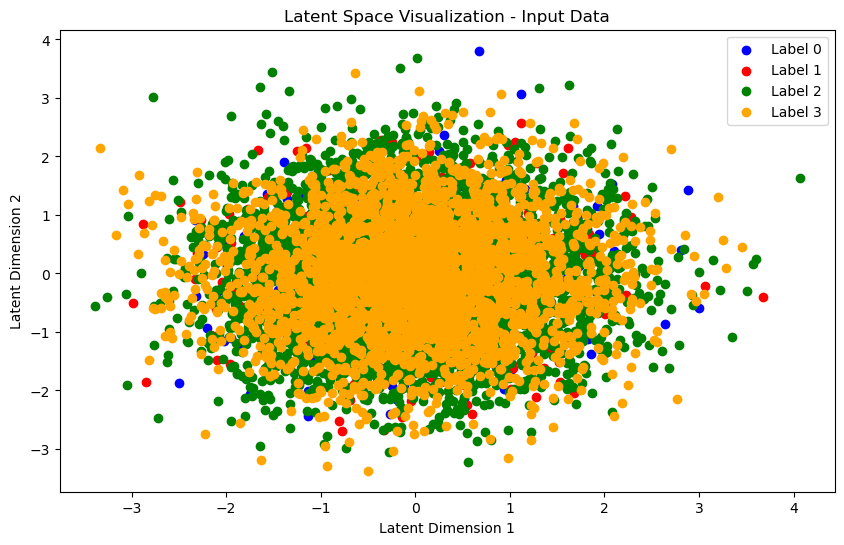

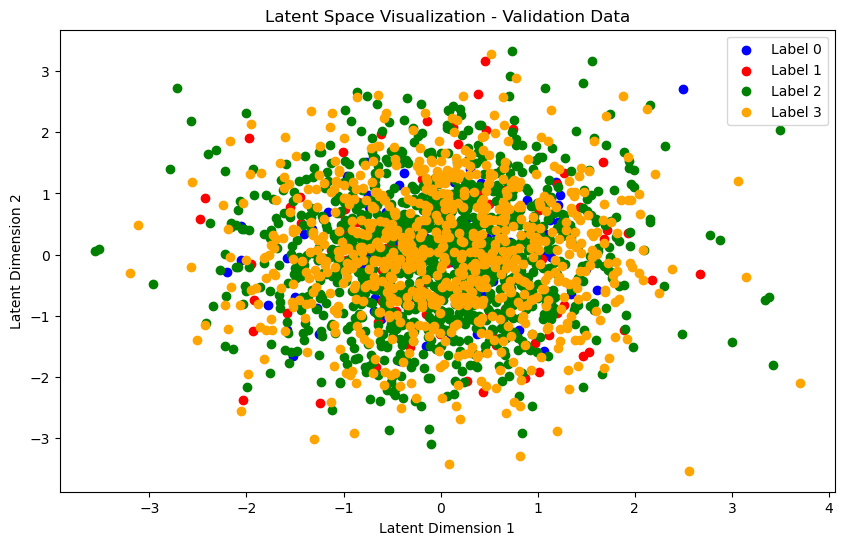

In [62]:
import matplotlib.pyplot as plt

# encode data into the latent space
_, _, encoded_x_train = vae.encoder.predict(x_train)
_, _, encoded_x_test = vae.encoder.predict(x_test)

label_colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

# input data
plt.figure(figsize=(10, 6))
for label in range(4):
    indices_train = np.where(y_train == label)[0]
    plt.scatter(encoded_x_train[indices_train, 0], encoded_x_train[indices_train, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Latent Space Visualization - Input Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

# validation data
plt.figure(figsize=(10, 6))
for label in range(4):
    indices_test = np.where(y_test == label)[0]
    plt.scatter(encoded_x_test[indices_test, 0], encoded_x_test[indices_test, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Latent Space Visualization - Validation Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()



66/66 [==============================] - 0s 821us/step


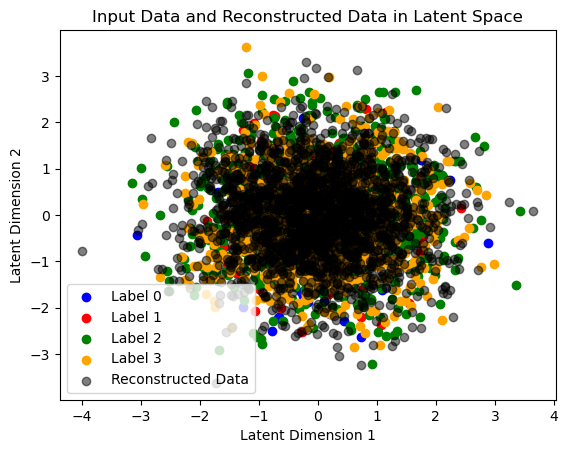

In [63]:
def plot_input_and_reconstructed_data(x_input_data, y_input_data):
    _, _, z_input = encoder.predict(x_input_data)
    reconstructed_data = vae.decoder.predict(z_input)
    _, _, recon_data_lsp = vae.encoder.predict(reconstructed_data)
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Input Data and Reconstructed Data in Latent Space")
    plt.legend()
    plt.show()

# Assuming `x_test` and `y_test` are the original input data
# and `reconstructed_x_test` is the reconstructed data obtained from the decoder
plot_input_and_reconstructed_data(x_test, y_test)


262/262 [==============================] - 0s 948us/step


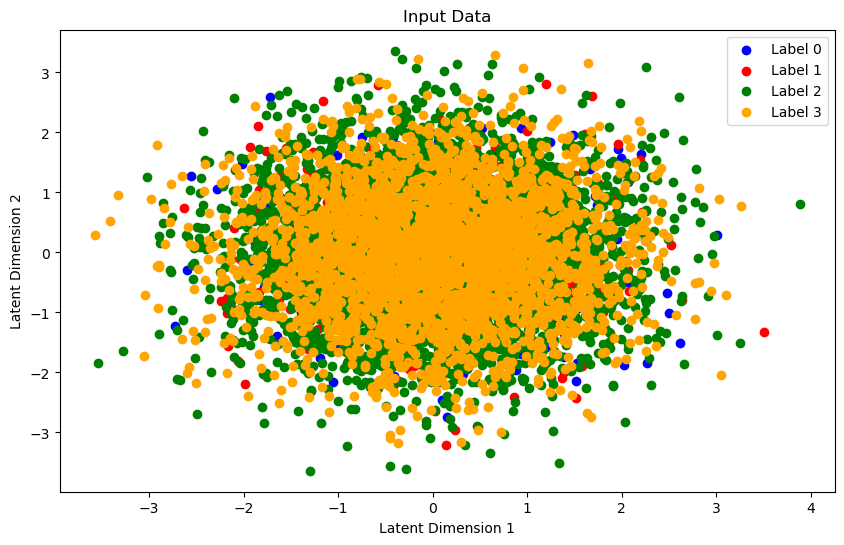

66/66 [==============================] - 0s 1ms/step


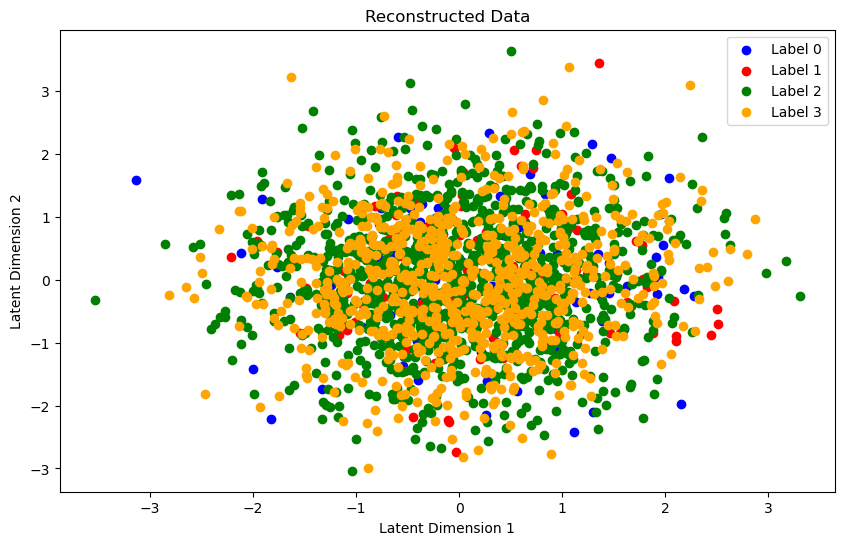

In [64]:
import matplotlib.pyplot as plt

def plot_input_data(encoder, x_data, y_data):
    _, _, z_input = encoder.predict(x_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Input Data")
    plt.legend()
    plt.show()

def plot_reconstructed_data(encoder, decoder, x_data, y_data):
    _, _, z = encoder.predict(x_data)
    reconstructed_data = decoder.predict(z)
    _, _, recon_data_lsp = encoder.predict(reconstructed_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Reconstructed Data")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plot_input_data(encoder, x_train, y_train) 

plt.figure(figsize=(10, 6))
plot_reconstructed_data(encoder, decoder, x_test, y_test)

In [65]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
    # Convert the sequences to Seq objects
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    # Perform global sequence alignment
    alignments = pairwise2.align.globalxx(seq1, seq2)

    # Get the alignment with the best score (the first one in the list)
    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    # Calculate similarity as a percentage
    similarity = (score / max(len(seq1), len(seq2))) * 100

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,100):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])/100
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])/100
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.23255814 0.39534884 0.18604651]
 [0.1025641  0.         0.12820513 ... 0.04347826 0.13157895 0.125     ]
 [0.20512821 0.28       0.23076923 ... 0.24       0.18421053 0.32      ]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.24324324 0.34210526 0.32432432]
 [0.33333333 0.17777778 0.26666667 ... 0.2        0.33333333 0.22222222]
 [0.07692308 0.25       0.15384615 ... 0.2173913  0.18421053 0.16666667]]
[[0.27272727 0.18604651 0.27906977 ... 0.13953488 0.27906977 0.20930233]
 [0.36363636 0.25581395 0.27906977 ... 0.09302326 0.3255814  0.1627907 ]
 [0.25       0.17241379 0.26666667 ... 0.2        0.14285714 0.3       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.17857143 0.26190476 0.28571429]
 [0.34090909 0.2972973  0.54054054 ... 0.13513514 0.28571429 0.24324324]
 [0.09090909 0.13793103 0.06666667 ... 0.33333333 0.0952381  0.17647059]]


In [66]:
_, _, encoded_x_train_dist = vae.encoder.predict(x_train)
_, _, encoded_x_test_dist = vae.encoder.predict(x_test)

66/66 [==============================] - 0s 985us/step


In [67]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def calculate_distance(latent_representations):
    num_peptides = len(latent_representations)
    distance_matrix = np.zeros((num_peptides, num_peptides))
    
    for i in range(num_peptides):
        for j in range(num_peptides):
            distance_matrix[i, j] = euclidean_distance(latent_representations[i], latent_representations[j])
    
    return distance_matrix

distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,100):
        dist_train = euclidean_distance(encoded_x_train_dist[i], encoded_x_train_dist[j])
        dist_test = euclidean_distance(encoded_x_train_dist[i], encoded_x_test_dist[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.708267   0.26070946 0.         ... 0.6259526  0.10844216 0.5561065 ]
 [0.6431471  0.14843914 0.4465599  ... 0.6429196  0.42565688 0.18386468]
 [0.47079378 0.35806122 0.5879358  ... 0.51281923 0.55626327 0.044031  ]
 ...
 [0.5199027  1.         0.860826   ... 0.36564076 0.94869524 1.        ]
 [0.2815094  0.6834684  0.5426031  ... 0.14174876 0.57183623 0.6684885 ]
 [0.10562276 0.8725574  0.86755073 ... 0.07286511 0.8941462  0.7073661 ]]
[[0.21743572 0.2836216  0.3912293  ... 0.51207733 0.5305189  0.464159  ]
 [0.17444494 0.07982609 0.01810396 ... 0.18516101 0.53505486 0.2781045 ]
 [0.3900247  0.2982483  0.15610886 ... 0.04197311 0.41357452 0.22808656]
 ...
 [1.         1.         0.99999994 ... 1.         0.623579   0.99999994]
 [0.6932901  0.6744162  0.6484885  ... 0.6186739  0.2029247  0.5726463 ]
 [0.8957761  0.8489131  0.780231   ... 0.7064676  0.362886   0.73588806]]


In [69]:
from scipy.stats import spearmanr, kendalltau, pearsonr

correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearman's Correlation:", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearson's Correlation:", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall's tau Correlation:", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearman's Correlation: -0.022151710238326443 -0.039027511956139606
p-value: 0.2682215433653331 0.05104003610727663
Pearson's Correlation: -0.005764714620615829 -0.039515358097046975
p-value: 0.7732748055417407 0.04820561232985058
Kendall's tau Correlation: -0.015142965356602206 -0.026418052516195303
p-value: 0.25829267596732985 0.04874495771737554
